## An example of Gaussian smoothing for 3D grids data in Fourier space.

### import python library
There is a bug so you must import Utils (something related to the Fourier transform) first!

In [1]:
from CosmAna import Main
import numpy as np
import matplotlib.pyplot as plt

### Toy data
Here, I create a toy data and used it to show how the `CosmAna` work when smoothing density field.

In [2]:
Ng = 32 # grids number per side
L = 300. # boxsize
data = np.zeros([Ng, Ng, Ng], dtype=np.float32)
pos = np.array([[Ng // 2, Ng // 2, Ng // 2],                   # set 4 particles position
                [Ng // 2 + 4, Ng // 2 - 3, Ng // 2 + 1],
                [2, 1, 1],                      
                [-1, -1, Ng // 2]])
for i, j, k in pos:                                         # assign particles into grids
    data[i, j, k] += 1

show the toy data in three direction

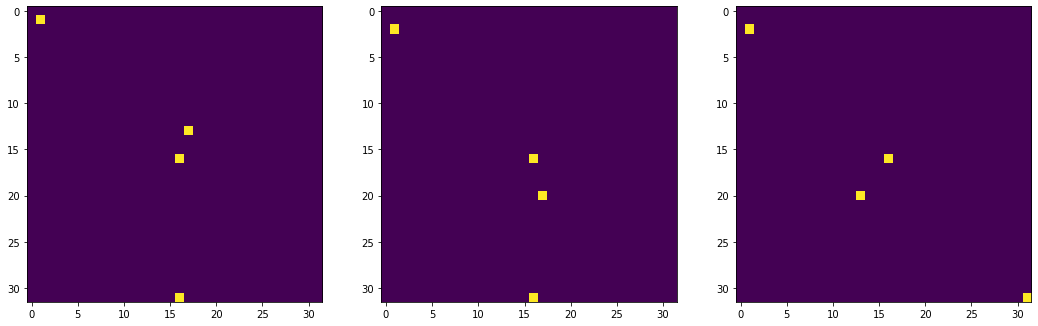

In [3]:
fig, ax = plt.subplots(figsize=[18,6],nrows=1, ncols=3)
ax[0].imshow(data.mean(axis=0))
ax[1].imshow(data.mean(axis=1))
ax[2].imshow(data.mean(axis=2))

### MPI IO
In `CosmAna`, there is a library named `MPI_IO`, which can be used to read or write binary data (C order) in parallel. The follow is an example to save and read the toy data.

- first, create a instance of the `Main` class

In [4]:
CA = Main(L=L, Ng=Ng)

parameters:
N: 32, L: 300.000000
data format: f4
fft precision: float!


- set file path

In [5]:
path = '/tmp/test.bin'

- Write data. The 3D field will be saved like `[(x0,y0,z0),(x0,y0,z1),(x0,y0,z2)...]`
or in C code:
```
for i in axis0:
    for j in axis1:
        for k in axis2:
            write data[i,j,k]
```

In [6]:
CA.tofile(data, path=path)

In [7]:
!ls -lth /tmp/test.bin

-rw-r--r-- 1 maotx users 128K Apr  1 17:52 /tmp/test.bin


- read it again. To do it, you should create a empty array first to allocate memory. After reading it, the data is saved in `mpi_io.datar` array, and its shape is [Ng*3]. You can reshape it to get original data shape [Ng,Ng,Ng]

In [8]:
data2 = CA.fromfile(path=path, shape=[CA.Ng, CA.Ng, CA.Ng], dtype=np.float32)

- check it

In [9]:
data2 = data2.reshape(Ng,Ng,Ng)
print(np.allclose(data, data2))

True


### Gaussian Smoothing

In [10]:
sigma = 15.

If you readdata by `MPI_IO`, you can use it directly. Otherwise, you should split the 3D array by the number of processes in the first axis, like:
```
data_mpi = np.array_split(data1, utils.comm.size)[utils.comm.rank]
```

In [11]:
datas = CA.Smooth(data, sigma)

`datas` is the smoothed field

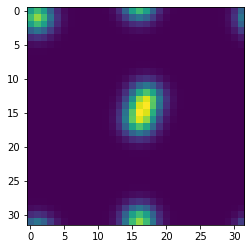

In [12]:
plt.imshow(datas.mean(axis=0))

### check the result by Gaussian smoothing in real space

In [13]:
def GaussInRealSpace(x, pos, sigma):
    H = CA.H
    Ng = CA.Ng
    zeros = np.zeros([Ng, Ng, Ng], dtype=np.float32)
    x = np.arange(Ng, dtype=np.float32)[:, None, None] + zeros
    y = np.arange(Ng, dtype=np.float32)[None, :, None] + zeros
    z = np.arange(Ng, dtype=np.float32)[None, None, :] + zeros
    for i, j, k in pos:
        dx = x - i
        dy = y - j
        dz = z - k
        dx[dx > Ng / 2] -= Ng
        dx[dx < -Ng / 2] += Ng
        dy[dy > Ng / 2] -= Ng
        dy[dy < -Ng / 2] += Ng
        dz[dz > Ng / 2] -= Ng
        dz[dz < -Ng / 2] += Ng
        dis = dx**2. + dy**2. + dz**2.
        w = 1. / np.sqrt(2. * np.pi * sigma**2.) * \
            np.exp(-0.5 * dis * H**2. / (sigma**2.))
        w /= w.sum()
        zeros += w
    return zeros

In [14]:
data_real = GaussInRealSpace(data, pos, sigma)

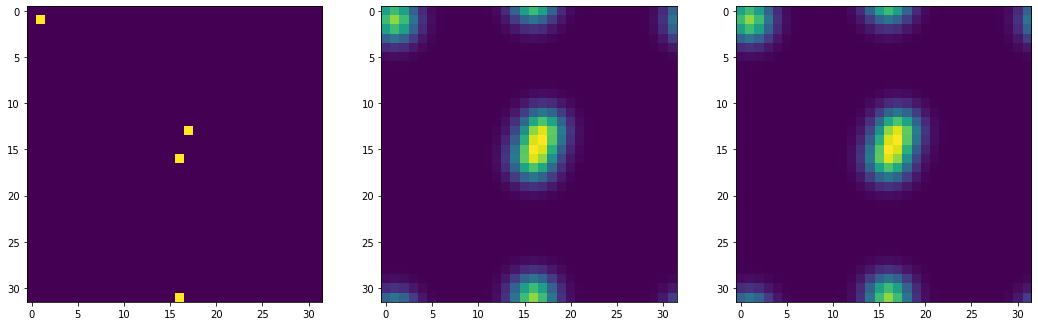

In [15]:
fig, ax = plt.subplots(figsize=[18,6],nrows=1, ncols=3)
ax[0].imshow(data.mean(axis=0))
ax[1].imshow(datas.mean(axis=0))
ax[2].imshow(data_real.mean(axis=0))

In [16]:
print(np.allclose(datas,data_real))

True


## MPI run

The above is an example for smoothing density in one process. The MPI script version is [this one](https://github.com/POFK/CosmAna/blob/master/CosmAna/exam/exam_smooth.py)
You can run this file by 
```
mpirun -np 4 python exam_smooth.py
```

In [17]:
from ipyparallel import Client
clients = Client(profile='mpi')
clients.block = True  # use synchronous computations\n",
print(clients.ids)

[0, 1, 2, 3]


In [18]:
%px %pylab inline 

[stdout:0] Populating the interactive namespace from numpy and matplotlib
[stdout:1] Populating the interactive namespace from numpy and matplotlib
[stdout:2] Populating the interactive namespace from numpy and matplotlib
[stdout:3] Populating the interactive namespace from numpy and matplotlib


In [12]:
with clients[:].sync_imports():
    from CosmAna import Main # must import this line first

importing Main from CosmAna on engine(s)


In [19]:
%%px
from CosmAna import Main
import numpy as np
Ng = 32 # grids number per side
L = 300. # boxsize
sigma = 15.

[stdout:0] 
parameters:
N: 32, L: 300.000000
data format: f4
fft precision: float!


[output:0]

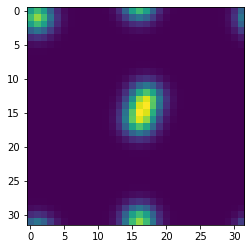

In [20]:
%%px
"""
float:
"""
CA = Main(L=L, Ng=Ng, format='f4') # if float, format='f4'; else if double, format='f8'
#==================== read data =============================
path = '/tmp/test.bin'
data = CA.fromfile(path=path, shape=[Ng, Ng, Ng], dtype=np.float32)
data = data.reshape([Ng//CA.size,Ng,Ng])
#==================== smoothing =============================
datas = CA.Smooth(data.astype(np.complex64), sigma)
#==================== save data =============================
CA.tofile(datas, path='/tmp/test_fs.bin')
#====================== check ===============================
if CA.rank == 0:
    import matplotlib.pyplot as plt
    s = np.fromfile('/tmp/test_fs.bin', dtype=np.float32)
    s = s.reshape(Ng,Ng,Ng)
    plt.imshow(s.mean(axis=0))
    plt.show()

In [21]:
path = '/tmp/test.bin'
data = np.fromfile(path, dtype=np.float32)
data = data.astype(np.float64)
data.tofile("/tmp/test_double.bin", format='f8')

[stdout:0] 
parameters:
N: 32, L: 300.000000
data format: f8
fft precision: double!


[output:0]

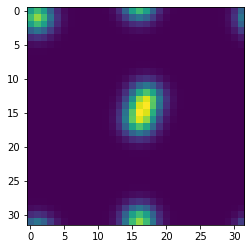

In [22]:
%%px
"""
double:
"""
CA = Main(L=L, Ng=Ng, format='f8') # if float, format='f4'; else if double, format='f8'
#==================== read data =============================
path = '/tmp/test_double.bin'

data = CA.fromfile(path=path, shape=[Ng, Ng, Ng], dtype=np.float64)
data = data.reshape([Ng//CA.size,Ng,Ng])
#==================== smoothing =============================
datas = CA.Smooth(data.astype(np.complex128), sigma)
#==================== save data =============================
CA.tofile(datas, path='/tmp/test_ds.bin')
#====================== check ===============================
if CA.rank == 0:
    import matplotlib.pyplot as plt
    s = np.fromfile('/tmp/test_ds.bin', dtype=np.float64)
    s = s.reshape(Ng,Ng,Ng)
    plt.imshow(s.mean(axis=0))
    plt.show()